# PBA Analysis
Ethan Woodbury

In this notebook, I examine data on PBA structures to get a feel for the data, etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Importing and Processing

Pre-processing:

In [2]:
with open('pba.json', 'r') as file :
  pba_json = file.read()

In [3]:
#Previewing the file:
print(pba_json[:100])

/* 1 */
{
    "_id" : ObjectId("58d009ea48a464edfdfb435d")
}

/* 2 */
{
    "_id" : ObjectId("58e5d1


As we can see, the file contains multiple json objects. Python is only capable of parsing one json object at a time, so we have to find a way to make python read only a single object while ignoring the rest of the file.

We also see that in the "\_id" field of each json object, there is a callable ObjectId term. This is not standard json format (or at least I wasn't able to get it to open when ObjectId was there), so let's get rid of it.

In [4]:
pba_json = pba_json.replace("ObjectId(", "")
pba_json = pba_json.replace(")", "")
print(pba_json[:50])

/* 1 */
{
    "_id" : "58d009ea48a464edfdfb435d"
}


Now we figure out how to parse the json objects. Because there are multiple json objects in the file, we will modify the file to be a list of objects, surrounded by square brackets and separated by commas.

In [5]:
for i in range(1,1000):
    j = str(i)
    pba_json = pba_json.replace('/* ' + j + ' */', ',')

print(pba_json[:100])

,
{
    "_id" : "58d009ea48a464edfdfb435d"
}

,
{
    "_id" : "58e5d103d95cbb63a64878f0",
    "input


In [6]:
#Adding square brackets:
pba_json = '[\n' + pba_json + '\n]'
print(pba_json[:52])

[
,
{
    "_id" : "58d009ea48a464edfdfb435d"
}

,
{



We also have to delete the first comma:

In [7]:
pba_json = pba_json[:2] + pba_json[3:]
print(pba_json[:50])

[

{
    "_id" : "58d009ea48a464edfdfb435d"
}

,
{


Finally, we save this string as a json file.

In [8]:
pba_json_formatted = open('pba_json_formatted.json', 'w')

In [9]:
pba_json_formatted.write(pba_json)
pba_json_formatted.close()

Now that the json file is in the correct format as an array of json objects, we can use the json library to import the file as a list of dictionaries (each dictionary is one object).

In [10]:
import json

In [11]:
with open('pba_json_formatted.json') as pba_json_formatted:  
    pba_dict = json.load(pba_json_formatted)

In [12]:
pba_dict[1]

{'_id': '58e5d103d95cbb63a64878f0',
 'input': {'structure': {'@module': 'pymatgen.core.structure',
   '@class': 'Structure',
   'lattice': {'matrix': [[9.95090252, -0.0003358, -0.0003358],
     [-0.0003358, 9.95090252, 0.0003358],
     [-0.0003358, 0.0003358, 9.95090252]],
    'a': 9.9509025313318,
    'b': 9.9509025313318,
    'c': 9.9509025313318,
    'alpha': 89.9961329643568,
    'beta': 90.0038670356432,
    'gamma': 90.0038670356432,
    'volume': 985.34295115756},
   'sites': [{'species': [{'element': 'Ca', 'occu': 1}],
     'abc': [0.75135993, 0.75127745, 0.75127745],
     'xyz': [7.4762048629286, 7.47588864272739, 7.47588864272739],
     'label': 'Ca'},
    {'species': [{'element': 'Ca', 'occu': 1}],
     'abc': [0.24872255, 0.24864007, 0.75127745],
     'xyz': [2.47467807727261, 2.4743618570714, 7.47588864272739],
     'label': 'Ca'},
    {'species': [{'element': 'Ca', 'occu': 1}],
     'abc': [0.24872255, 0.75127745, 0.24864007],
     'xyz': [2.47467807727261, 7.475888642727

In [13]:
pba_dict[1]['input']['structure']['sites'][8]['species'][0]['element']

'Co'

We now have all of the data stored in a Python dictionary pba_data.

## Data Exploration

First let's check how many structures are in the file:

In [14]:
print(len(pba_dict))

536


Let's start by looking at the energy_per_atom values for each of the 536 structures. We'll put each of them into a pandas dataframe along with the \_id value.

In [15]:
pba_df = pd.DataFrame(np.zeros([536,2]), columns = ['_id', 'energy_per_atom'])
pba_df.loc[:,'energy_per_atom'] = np.nan
pba_df.head()

,_id,energy_per_atom
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN


In [16]:
for struct in range(len(pba_dict)):
    pba_df.loc[struct,'_id'] = pba_dict[struct]['_id']
    if 'output' in pba_dict[struct].keys():
        pba_df.loc[struct,'energy_per_atom'] = pba_dict[struct]['output']['energy_per_atom']
pba_df.head()

,_id,energy_per_atom
0,58d009ea48a464edfdfb435d,NaN
1,58e5d103d95cbb63a64878f0,-7.947785
2,58e5d318d95cbb63a648790f,-8.352124
3,58e5d53cd95cbb63a6487922,-8.191138
4,58e5d670d95cbb63a6487926,-8.412139


(array([ 28.,  93., 122., 114.,  66.,  64.,  36.,   8.,   1.,   3.]),
 array([-8.75336718, -8.58594518, -8.41852317, -8.25110116, -8.08367915,
        -7.91625714, -7.74883513, -7.58141313, -7.41399112, -7.24656911,
        -7.0791471 ]),
 <a list of 10 Patch objects>)

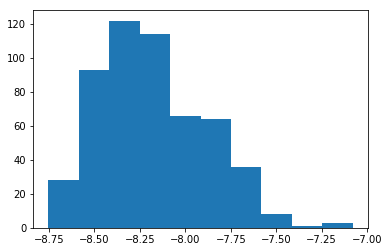

In [17]:
#The np.isfinite code excludes NaN values from the histogram.
plt.hist(pba_df['energy_per_atom'][np.isfinite(pba_df['energy_per_atom'])])

### Parsing for Composition:
Let's add the atoms for each structure into the same dataframe.

In [18]:
#Creating new columns in df:
pba_df['A_atom'], pba_df['P_atom'], pba_df['R_atom'] = np.nan, np.nan, np.nan

In [19]:
for struct in range(len(pba_dict)):
    if 'input' in pba_dict[struct].keys():
        pba_df.loc[struct,'A_atom'] = pba_dict[struct]['input']['structure']['sites'][0]['species'][0]['element']
        pba_df.loc[struct,'P_atom'] = pba_dict[struct]['input']['structure']['sites'][4]['species'][0]['element']
        pba_df.loc[struct,'R_atom'] = pba_dict[struct]['input']['structure']['sites'][8]['species'][0]['element']
pba_df.head()

,_id,energy_per_atom,A_atom,P_atom,R_atom
0,58d009ea48a464edfdfb435d,NaN,NaN,NaN,NaN
1,58e5d103d95cbb63a64878f0,-7.947785,Ca,Fe,Co
2,58e5d318d95cbb63a648790f,-8.352124,Mg,Cr,Os
3,58e5d53cd95cbb63a6487922,-8.191138,Ca,Mn,Fe
4,58e5d670d95cbb63a6487926,-8.412139,Ca,Mn,Os


Now that we have the identity of the atom in each site, let's look at how energy is related to the identity of the atom in each site.

In [20]:
pba_by_A_atom = pba_df[['energy_per_atom','A_atom']].groupby('A_atom', as_index = False).mean()
pba_by_A_atom

,A_atom,energy_per_atom
0,C,-7.079147
1,Ca,-8.186986
2,K,-8.230262
3,Li,-8.172056
4,Mg,-8.073475
5,Na,-8.193177
6,Sr,-8.238501


In [21]:
#There shouldn't be a carbon in the A site, so let's just delete that entry for this bar graph.
pba_by_A_atom = pba_by_A_atom.drop(0)

Text(0,0.5,'Energy per atom (meV)')

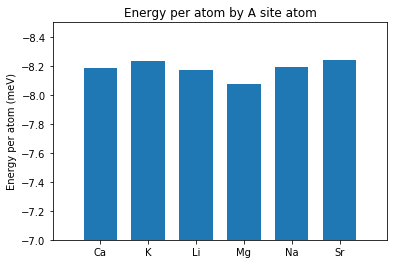

In [22]:
plt.bar(pba_by_A_atom['A_atom'],pba_by_A_atom['energy_per_atom'], width = 0.7)
plt.axis([-1,6,-7,-8.5])
plt.title('Energy per atom by A site atom')
plt.ylabel('Energy per atom (meV)')

Text(0,0.5,'Energy per atom (meV)')

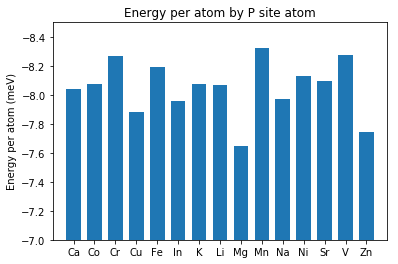

In [23]:
#Doing the same thing for P site atom:
pba_by_P_atom = pba_df[['energy_per_atom','P_atom']].groupby('P_atom', as_index = False).mean()
pba_by_P_atom = pba_by_P_atom.drop(0)
plt.bar(pba_by_P_atom['P_atom'],pba_by_P_atom['energy_per_atom'], width = 0.7)
plt.axis([-1,15,-7,-8.5])
plt.title('Energy per atom by P site atom')
plt.ylabel('Energy per atom (meV)')

Obviously, several of these atoms are not suitable P site atoms, such as Ca, K, and Li. I will do some more digging to figure out why these were output as P site atoms.

Text(0,0.5,'Energy per atom (meV)')

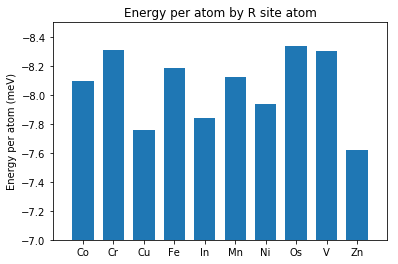

In [24]:
#Doing the same thing for R site atom:
pba_by_R_atom = pba_df[['energy_per_atom','R_atom']].groupby('R_atom', as_index = False).mean()
pba_by_R_atom = pba_by_R_atom.drop(6) #Drops entry with N as R site atom
plt.bar(pba_by_R_atom['R_atom'],pba_by_R_atom['energy_per_atom'], width = 0.7)
plt.axis([-1,10,-7,-8.5])
plt.title('Energy per atom by R site atom')
plt.ylabel('Energy per atom (meV)')

Again, some of these atoms should not be listed as R site atoms, so more data cleaning will likely need to be done. Specifically, I will have to account for each structure having a different number of A atoms.

Just from these graphs, we do not know whether any particular atoms are more likely to have stable electrode structures. We will have to do more detailed analyses using the pymatgen library.